In [0]:
%matplotlib inline
from fastai.basics import *

# Prepare Data

In [2]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-03-21 09:30:06--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.1’

mnist.pkl.gz.1      100%[===================>]  15.42M  4.03MB/s    in 5.1s    

2019-03-21 09:30:11 (3.03 MB/s) - ‘mnist.pkl.gz.1’ saved [16168813/16168813]



In [0]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

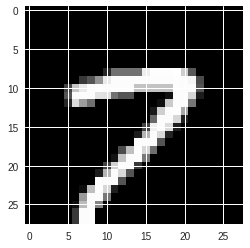

In [4]:
plt.imshow(x_train[123].reshape((28,28)), cmap="gray")
x_train.shape

In [0]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))   # convert to torch.tensor, so pytorch can handle it
n,c = x_train.shape  # n -->  number of samples     c --> number of classes

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)  # train and valid are tied together, shuffled, etc.

In [7]:
x,y = next(iter(data.train_dl))                   # her we get one mini_batch of size 64
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

# very simple architecture with no hidden layer

In [0]:
class Mnist_Logistic(nn.Module):                  # our mnist-function inherits from pytorch nn.Module.  
    def __init__(self):
        super().__init__()                        # prepare the module
        self.lin = nn.Linear(784, 10, bias=True)  # one linear layer, the output-Layer, no hidden layer, including a bias for each neuron on this layer
 
    def forward(self, xb): return self.lin(xb)    # if the model gets called, pytroch will call forward for us. xb is 64x784 matrix, the mini_batch of images. forward returns the matrix-dot-product of xb x self.lin 

In [0]:
model = Mnist_Logistic().cuda()                   # create the model and attach to the cpu

In [10]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [11]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [12]:
model(x).shape                                   # here we call the model, which results in a call of the method forward. So the shape here is the output of the model

torch.Size([64, 10])

In [13]:
[p.shape for p in model.parameters()]            # the weights of the model. 10x784 matrix for the matrix-dot-product and a bias for each output neuron

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr=2e-2                                          # learingnrate

In [0]:
loss_func = nn.CrossEntropyLoss()                # loss function 

In [0]:
def update(x,y,lr):
    wd = 1e-5                                    # weight-decay
    y_hat = model(x)                             # calculate output
    # weight decay
    w2 = 0.                                           
    for p in model.parameters(): w2 += (p**2).sum()   # for every parameter, get the square of weights and sum up and add to w2
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd                # get the loss  of the predictions and and w2*wd (this penalizes larger weight values)
    loss.backward()                              # calculate the derivative of this function
    with torch.no_grad():                        # The following should not be included in the derivation
        for p in model.parameters():             # iterate over every parameter
            p.sub_(lr * p.grad)                  # substract the product of learningrate and gradient
            p.grad.zero_()                       # reset the gradient
    return loss.item()                           # return the value of the loss

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]  # do one epoch on the train-data and store the losses

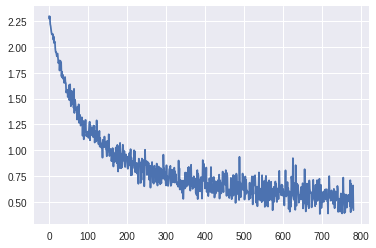

In [18]:
plt.plot(losses);

# A real NN with one hidden layer

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)    # 784x50 matrix with bias
        self.lin2 = nn.Linear(50, 10, bias=True)     # 50x10 matrix with bias
                                                     # the architecture is 784 ---> 50 ---> 10  (hidden layer with 50 neurons)
    def forward(self, xb):
        x = self.lin1(xb)                            # calculate the first matrix-dot-product
        x = F.relu(x)                                # add a non-linear-function: relu is (max(0, x)). So negative values will be zero
        return self.lin2(x)                          # return the result of the last matrix-dot-product

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]  # use the update-method defined for the "net" with no hidden layer

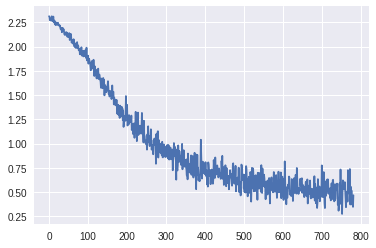

In [22]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):                              
    opt = optim.Adam(model.parameters(), lr)      # use a in-built opimizer instead of our custom Gradient Descent
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()                                    # update the parameters with the gradient           
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

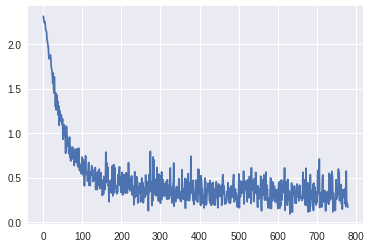

In [26]:
plt.plot(losses);

# the same using fast.ai - Learner

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)    # the same as above but a lot simpler, still using our own architecture

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


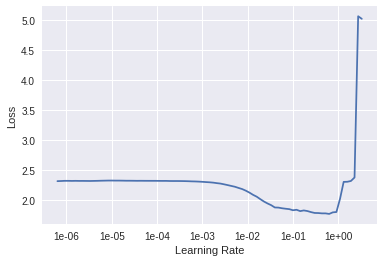

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 1e-2)                                               # a way better result

epoch,train_loss,valid_loss,accuracy,time
0,0.141371,0.129983,0.963200,00:05


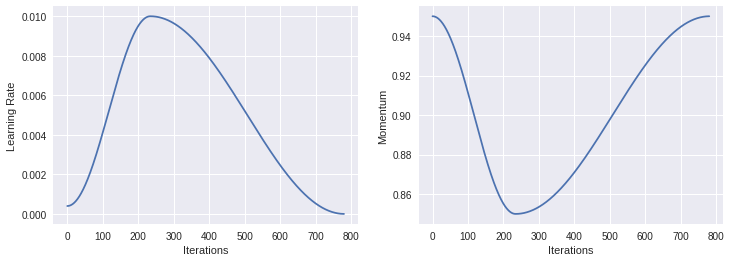

In [30]:
learn.recorder.plot_lr(show_moms=True)                                     # fastai changes the learning rate during the epoch

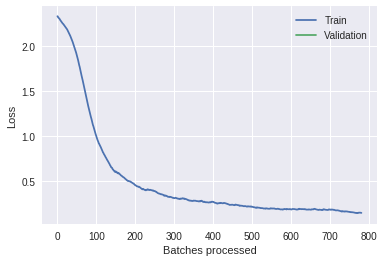

In [31]:
learn.recorder.plot_losses()